# Running Stan on Jupyter or JuliaBox

## Introduction to Stan and Stan.jl on Jupyter and JuliaBox

Stan ( http://mc-stan.org ) is one of several tools available to perform Bayesian sampling. Statistical inference based on Stan's result (the posterior samples in 1 or more chains) are typically done in R, Python or Matlab. Stan.jl uses Stan as an external program and simplifies running Stan models and subsequent inference, all from within Julia, thus providing aother 'interface' to Stan.

Stan is written in C++ but still attractive to Julia users because it is a very good tool for users interested in Bayesian models that can be efficiently sampled with Stan. It is also supported by a very capable team and community willing to help out with modeling and installation issues. Reasons enough for the existance of Stan.jl.

For Julia users who prefer a Notebook-like interface (over a Julia REPL + Editor interface), Jupyter is available and this Notebook demonstrates one way of using Stan.jl in a Notebook, including several options for the graphical display of results.

JuliaBox contributes another major benefit in that it removes the burden of installing Stan from the end users. The user still has a 'private' permanent file system to store Julia scripts that include the Stan model and available data. 

Finally, pushing Stan's envelope can require knowledge of C++, C++ templates, the C++ Boost libraries, R, the Stan modeling language, and its extensions (e.g. functions). This can be a daunting task. Stan.jl can't help here but Julia's ecosystem provides options entirely written in Julia, like Mamba.jl ( http://mambajl.readthedocs.org/en/latest/index.html ) and Lora.jl which, if access to lower level MCMC functionality is required, might be a better route. Using Stan.jl will pave the way to such a migration.

## Getting started, some preliminaries ...

Running below cell is occasionally useful to make sure all packages are up to date.

In [1]:
#Pkg.update()

Stan.jl relies on Mamba.jl's very broad collection of functions for posterior inference and display after the MCMC sampling has been performed by Stan.

In [2]:
using Mamba, Stan;

In this example we'll use one of several examples that are included in Stan.jl, i.e. estimating the distribution of the success probability (theta) based on 4 sets of 10 observed outcomes.

I like to control where I store intermediate and result files. In this case I 'borrow' the Bernoulli directory inside Stan.jl.

In [3]:
old = pwd()
ProjDir = Pkg.dir("Stan", "Examples", "Mamba", "Bernoulli")
cd(ProjDir)

## A Stan model and its data

Define a simple Stan model. On JuliaBox it is best to define the model inline, but it could also be stored in an external file and uploaded to JuliaBox.

In [4]:
bernoullimodel = "
data { 
  int<lower=0> N; 
  int<lower=0,upper=1> y[N];
} 
parameters {
  real<lower=0,upper=1> theta;
} 
model {
  theta ~ beta(1,1);
    y ~ bernoulli(theta);
}
";

Define the observed data, in this case the number of observations in the 4 experiments and the outcomes of these observations. This is an array of dictionaries. By default Stan will run 4 chains and in this setup each chain is assigned a dictionary with the results of 1 experiment. If that is an acceptable way to analyze these results depends on the purpose of the 4 experiments. It's used here purely as an illustration, e.g. one could increase the probability of success in one of the experiment by updating the y vector. This will show up in the overall value of theta below and in the plots for that chain.

In [5]:
bernoullidata = [
  Dict("N" => 10, "y" => [0, 1, 0, 1, 0, 0, 0, 0, 0, 1]),
  Dict("N" => 10, "y" => [0, 1, 0, 0, 0, 0, 1, 0, 0, 1]),
  Dict("N" => 10, "y" => [0, 0, 0, 0, 0, 0, 1, 0, 1, 1]),
  Dict("N" => 10, "y" => [0, 0, 0, 1, 1, 0, 0, 1, 0, 1])
];

## Setting up a Stanmodel and sampling from the model

Stanmodel() and stan() are the main functions provided by Stan.jl. For details on the arguments of these functions see the CmdStan documentation and the README in Stan.jl ( https://github.com/goedman/Stan.jl )

In [18]:
stanmodel = Stanmodel(num_samples=1200, thin=2, name="bernoulli", model=bernoullimodel);


File /Users/rob/.julia/v0.5/Stan/Examples/Mamba/Bernoulli/tmp/bernoulli.stan will be updated.



In [20]:
rc, sim1 = stan(stanmodel, bernoullidata, ProjDir, diagnostics=false);


make: `/Users/rob/.julia/v0.5/Stan/Examples/Mamba/Bernoulli/tmp/bernoulli' is up to date.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: bernoulli_model
4 chains: each with iter=(600,600,600,600); warmup=(0,0,0,0); thin=(2,2,2,2); 2400 iterations saved.

Warmup took (0.015, 0.015, 0.015, 0.015) seconds, 0.061 seconds total
Sampling took (0.026, 0.025, 0.023, 0.021) seconds, 0.094 seconds total

                Mean     MCSE  StdDev    5%   50%   95%  N_Eff  N_Eff/s    R_hat
lp__            -8.3  1.9e-01    0.79  -9.7  -8.1  -7.6     18      189  1.1e+00
accept_stat__   0.91  2.7e-03    0.13  0.62  0.97   1.0   2400    25515  1.0e+00
stepsize__       1.1  8.5e-02    0.12  0.94   1.1   1.3    2.0       21  7.7e+13
treedepth__      1.4  1.0e-02    0.49   1.0   1.0   2.0   2362    25112  1.0e+00
n_leapfrog__     2.4  2.1e-02    0.98   1.0   3.0   3.0   2186    23242  1.0e+00
divergent__     0.00  0.0e+00    0.00  0.00  0

In [21]:
# Check for rc == 0
rc

0

From above summary you can see that by default Stan.jl runs 4 chains. Stan will not perform any thinning, this is done later on in fact as we defined a thinning factor of 2 in the Stanmodel() call.

Notice that if we were to run the simulation again the Stan Model would not be compiled unless the model has been changed. 

## Posterior analysis

Stan records 6 variables by default augmented by model specific variables (only theta in this example). Not all of these are suitable for posterior inference. In this example we'll only perform posterior analysis on "theta", "lp__" and "accept_stat__".

In some cases Stan might record 10s, 100s even 1000s of model specific variables. In those cases a variable like 'posterior' can be used to constrain the number of variables used in posterior analysis.

In [22]:
posterior = ["theta", "lp__", "accept_stat__"];

Apply the subset 'posterior' before calling describe().

In [23]:
sim = sim1[:, posterior, :]
describe(sim)

Iterations = 1:300
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 300

Empirical Posterior Estimates:
                  Mean        SD       Naive SE       MCSE       ESS   
        theta  0.35504490 0.13563072 0.0039153217 0.011266732 144.91731
         lp__ -8.27142100 0.80863480 0.0233432761 0.070811772 130.40491
accept_stat__  0.91328574 0.13435705 0.0038785541 0.004807344 300.00000

Quantiles:
                  2.5%       25.0%      50.0%      75.0%      97.5%   
        theta   0.1261384  0.25477925  0.339640  0.4478765  0.64176875
         lp__ -10.3832925 -8.45837750 -8.110565 -7.7416975 -7.63911925
accept_stat__   0.5073997  0.88417225  0.970553  1.0000000  1.00000000



Mamba.jl provides a range of function to diagnose and analyze the simulation result, e.g. gelmandiag() is shown below. See the Mamba documentation ( http://mambajl.readthedocs.org/en/latest/index.html ) or the Bernoulli example in Stan.jl for other options.

In [24]:
gelmandiag(sim, mpsrf=true, transform=true)

               PSRF 97.5%
        theta 1.059 1.170
         lp__ 1.096 1.249
accept_stat__ 1.016 1.031
 Multivariate 1.322   NaN



## Plot the results

In [25]:
p = plot(sim, [:trace, :mean, :density, :autocor], legend=true);

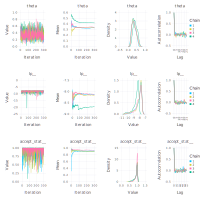

In [26]:
draw(p, ncol=4)

## Housekeeping ...

Intermediate results are all in the 'tmp' directory. Results that you might want to keep around are left in the current working directory (ProjDir as defined above).

In [27]:
;ls

bernoulli.jl
tmp


What's in the 'tmp' directory?

In [28]:
;ls tmp

bernoulli
bernoulli.hpp
bernoulli.stan
bernoulli_1.data.R
bernoulli_2.data.R
bernoulli_3.data.R
bernoulli_4.data.R
bernoulli_build.log
bernoulli_run.log
bernoulli_samples_1.csv
bernoulli_samples_2.csv
bernoulli_samples_3.csv
bernoulli_samples_4.csv


##### You can remove the 'tmp' directory. If you do this, future simulations will require redefinition of the Stanmodel() and recompilation when calling stan()!

In [29]:
isdir("tmp") && rm("tmp", recursive=true)